In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from glove import *
import myUtils

import pandas as pd
from pandas.io.json._normalize import nested_to_record
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Load GloVe model and dataset**

In [3]:
glove_model = GloveModel.from_pretrained('../trained_models/el.glove.300.txt')

In [4]:
review_dict = myUtils.read_json_v2('../data/reviews_revision.json')
reviews = pd.DataFrame.from_dict(nested_to_record(review_dict, sep='_'))
reviews.drop(columns='_id_$oid', inplace=True)

# Drop columns that will not be used
reviews.drop(columns=['meta_product_name', 'meta_product_type', \
                      'meta_review_pros', 'meta_review_so-so', 'meta_review_cons'], inplace=True)

**Get ids from words using GloVe model**

In [5]:
reviews['ids'] = reviews['text'].apply(glove_model.string_to_ids)
reviews['ids_length'] = reviews['ids'].apply(len)

**Remove outliers (entries with very long length)**

In [6]:
q_hi = reviews['ids_length'].quantile(0.95)
reviews = reviews[reviews['ids_length'] < q_hi].reset_index(drop=True)

In [7]:
reviews['ids_length'].describe()

count    756.000000
mean      68.503968
std       49.414331
min        5.000000
25%       32.000000
50%       54.000000
75%       95.250000
max      227.000000
Name: ids_length, dtype: float64

In [8]:
reviews.sample(5)

,text,meta_review_sentiment,ids,ids_length
23,Παιδιά μην κάνετε το λάθος και το πάρετε τώρα ...,negative,"[151, 110, 725, 4, 844, 3, 4, 3273, 141, 12, 2...",103
628,"Τα αγόρασα την προηγούμενη περίοδο καραντίνας,...",positive,"[14, 13558, 9, 1501, 352, 95419, 1, 52, 545, 1...",112
551,Η ροδέλα δεν ανταποκρίνεται ούτε τις μισές φορ...,negative,"[8, 56071, 28, 5785, 173, 31, 16990, 259, 12, ...",32
535,θα εβαζα 5/5 αστερια αλλα με ενοχλουν στα αυτι...,neutral,"[24, 23329, 38, 5032, 42, 10, 18933, 44, 5407,...",34
570,"Για τα λεφτά του είναι παραπάνω από καλό, το μ...",positive,"[11, 14, 1934, 5, 17, 355, 13, 310, 1, 4, 77, ...",44


**Pad ids of each entry to match their length**

In [9]:
padded_ids = keras.preprocessing.sequence.pad_sequences(
    reviews['ids'].to_numpy(), padding="post", value=0
)

**Initialize embeddings layer with the weights of the GloVe model**

In [10]:
embeddings_layer = keras.layers.Embedding(
    input_dim=glove_model.emb_norm.shape[0], output_dim=glove_model.emb_norm.shape[1],
    weights=[glove_model.emb_norm], name='embeddings', mask_zero=True
)

**Build model**

In [11]:
LSTM_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(padded_ids.shape[1],)),
    embeddings_layer,
    keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    keras.layers.Dense(3, activation='softmax')
])

In [12]:
LSTM_model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=keras.metrics.CategoricalAccuracy())

In [13]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 227, 300)          120000000 
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 120,440,067
Trainable params: 120,440,067
Non-trainable params: 0
_________________________________________________________________


**Transform target labels to one-hot encoding**

In [14]:
onehot = OneHotEncoder(sparse=False)

In [15]:
encoded_sentiment = onehot.fit_transform(reviews['meta_review_sentiment'].values.reshape(-1,1))

**Train-Test split**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_ids, encoded_sentiment, test_size=0.25, random_state=0
)

**Fit model**

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                                                  restore_best_weights=True)

history = LSTM_model.fit(
    x=X_train, y=y_train, epochs=50, validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
15/15 [==============================] - 34s 2s/step - loss: 1.1009 - accuracy: 0.3311 - val_loss: 1.0994 - val_accuracy: 0.3772
Epoch 2/50
15/15 [==============================] - 21s 1s/step - loss: 1.0892 - accuracy: 0.4194 - val_loss: 1.0990 - val_accuracy: 0.4035
Epoch 3/50
15/15 [==============================] - 22s 1s/step - loss: 1.0815 - accuracy: 0.4503 - val_loss: 1.0984 - val_accuracy: 0.3772
Epoch 4/50
15/15 [==============================] - 29s 2s/step - loss: 1.0726 - accuracy: 0.5298 - val_loss: 1.0943 - val_accuracy: 0.4386
Epoch 5/50
15/15 [==============================] - 20s 1s/step - loss: 1.0636 - accuracy: 0.5519 - val_loss: 1.0902 - val_accuracy: 0.4211
Epoch 6/50
15/15 [==============================] - 22s 1s/step - loss: 1.0537 - accuracy: 0.5717 - val_loss: 1.0874 - val_accuracy: 0.4474
Epoch 7/50
15/15 [==============================] - 20s 1s/step - loss: 1.0401 - accuracy: 0.5872 - val_loss: 1.0818 - val_accuracy: 0.4561
Epoch 8/50
15/15 [==

**Evaluate model**

In [18]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 1.35908555239439)

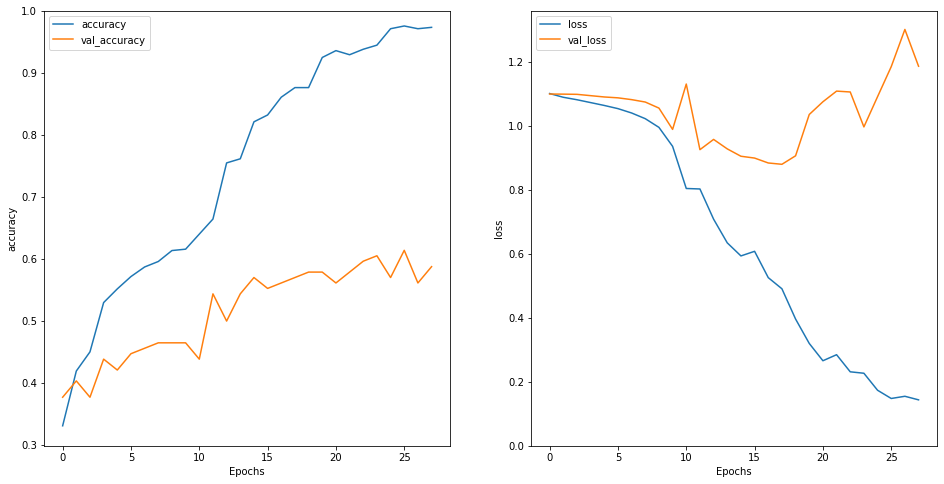

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'categorical_accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
y_pred = LSTM_model.predict(X_test)

# Convert to integer {0: negative, 1: neutral, 2: positive}
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [21]:
print('Confusion matrix\n')
print(metrics.confusion_matrix(y_test, y_pred))
print('\n')

print(metrics.classification_report(y_test, y_pred))

Confusion matrix

[[56  6  8]
 [17 24 21]
 [ 5 12 40]]


              precision    recall  f1-score   support

           0       0.72      0.80      0.76        70
           1       0.57      0.39      0.46        62
           2       0.58      0.70      0.63        57

    accuracy                           0.63       189
   macro avg       0.62      0.63      0.62       189
weighted avg       0.63      0.63      0.62       189

